In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.patches import Circle, Rectangle, Arc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

%matplotlib inline
sns.set()

pd.set_option('display.max_columns', None)

## Load data

In [2]:
df = pd.read_csv('../../data/merged_tracking_shots.csv')

df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,EVENTMSGACTIONTYPE,SCOREMARGIN,AVERAGE_DEFENDER_DISTANCE,SHOOTER_DEFENDER_DISTANCE,OFFENSE_SPACING,DEFENSE_SPACING,SHOT_CLOCK,ACTION_TYPE_SIMPLIFIED
0,0,0,0,9547,9547.0,Shot Chart Detail,21500433,72,201589,Darrell Arthur,1610612743,Denver Nuggets,1,3,41,Made Shot,Jump Shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,18,64,169,1,1,20151223,PHX,DEN,1.0,4.0,9.850909,16.651954,646.662757,107.603674,14.38,Jump Shot
1,1,1,2,9549,9549.0,Shot Chart Detail,21500433,91,201589,Darrell Arthur,1610612743,Denver Nuggets,1,1,21,Made Shot,Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),16-24 ft.,17,171,-1,1,1,20151223,PHX,DEN,1.0,3.0,9.792545,15.191194,433.787390,103.901113,12.14,Jump Shot
2,2,2,5,9552,9552.0,Shot Chart Detail,21500433,127,201589,Darrell Arthur,1610612743,Denver Nuggets,2,9,43,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),16-24 ft.,17,169,-24,1,0,20151223,PHX,DEN,1.0,16.0,9.551649,8.720667,366.062721,58.935462,8.03,Jump Shot
3,3,3,7,9554,9554.0,Shot Chart Detail,21500433,321,201589,Darrell Arthur,1610612743,Denver Nuggets,3,4,34,Missed Shot,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,25,182,174,1,0,20151223,PHX,DEN,1.0,1.0,7.960229,17.402713,677.392732,267.826654,15.89,Jump Shot
4,4,4,8,9555,9555.0,Shot Chart Detail,21500433,356,201589,Darrell Arthur,1610612743,Denver Nuggets,3,2,14,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,14,146,-21,1,0,20151223,PHX,DEN,1.0,10.0,12.331514,6.678257,913.120564,202.175181,11.94,Jump Shot


#### Looks like we have some missing value for `SHOT_CLOCK` which we can probably drop

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65342 entries, 0 to 65341
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 65342 non-null  int64  
 1   Unnamed: 0.1               65342 non-null  int64  
 2   Unnamed: 0.1.1             65342 non-null  int64  
 3   Unnamed: 0.1.1.1           65342 non-null  int64  
 4   Unnamed: 0.1.1.1.1         61201 non-null  float64
 5   GRID_TYPE                  65342 non-null  object 
 6   GAME_ID                    65342 non-null  int64  
 7   GAME_EVENT_ID              65342 non-null  int64  
 8   PLAYER_ID                  65342 non-null  int64  
 9   PLAYER_NAME                65342 non-null  object 
 10  TEAM_ID                    65342 non-null  int64  
 11  TEAM_NAME                  65342 non-null  object 
 12  PERIOD                     65342 non-null  int64  
 13  MINUTES_REMAINING          65342 non-null  int

In [4]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       'Unnamed: 0.1.1.1.1', 'GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID',
       'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_NAME', 'PERIOD',
       'MINUTES_REMAINING', 'SECONDS_REMAINING', 'EVENT_TYPE', 'ACTION_TYPE',
       'SHOT_TYPE', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE',
       'SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'SHOT_ATTEMPTED_FLAG',
       'SHOT_MADE_FLAG', 'GAME_DATE', 'HTM', 'VTM', 'EVENTMSGACTIONTYPE',
       'SCOREMARGIN', 'AVERAGE_DEFENDER_DISTANCE', 'SHOOTER_DEFENDER_DISTANCE',
       'OFFENSE_SPACING', 'DEFENSE_SPACING', 'SHOT_CLOCK',
       'ACTION_TYPE_SIMPLIFIED'],
      dtype='object')

In [5]:
df = df[['SHOT_TYPE', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'AVERAGE_DEFENDER_DISTANCE', 'SHOOTER_DEFENDER_DISTANCE',
       'OFFENSE_SPACING', 'DEFENSE_SPACING', 'SHOT_CLOCK', 'ACTION_TYPE_SIMPLIFIED', 'SHOT_MADE_FLAG']]

In [6]:
df['SHOT_ZONE_BASIC'].unique()

array(['Mid-Range', 'Above the Break 3', 'Restricted Area',
       'In The Paint (Non-RA)', 'Left Corner 3', 'Right Corner 3',
       'Backcourt'], dtype=object)

In [7]:
df['SHOT_ZONE_RANGE'].unique()

array(['16-24 ft.', '24+ ft.', '8-16 ft.', 'Less Than 8 ft.',
       'Back Court Shot'], dtype=object)

In [8]:
df['SHOT_ZONE_AREA'].unique()

array(['Right Side Center(RC)', 'Right Side(R)', 'Center(C)',
       'Left Side(L)', 'Left Side Center(LC)', 'Back Court(BC)'],
      dtype=object)

#### Since `Back court` shots are just noise for us, we shall get rid of them

In [9]:
df = df[(df['SHOT_ZONE_BASIC'] != 'Backcourt')]
df = df[(df['SHOT_ZONE_AREA'] != 'Back Court(BC)')]
df = df[(df['SHOT_ZONE_RANGE'] != 'Back Court Shot')]

print(df['SHOT_ZONE_BASIC'].unique(), df['SHOT_ZONE_AREA'].unique(), df['SHOT_ZONE_RANGE'].unique())

['Mid-Range' 'Above the Break 3' 'Restricted Area' 'In The Paint (Non-RA)'
 'Left Corner 3' 'Right Corner 3'] ['Right Side Center(RC)' 'Right Side(R)' 'Center(C)' 'Left Side(L)'
 'Left Side Center(LC)'] ['16-24 ft.' '24+ ft.' '8-16 ft.' 'Less Than 8 ft.']


In [10]:
df.describe()

,AVERAGE_DEFENDER_DISTANCE,SHOOTER_DEFENDER_DISTANCE,OFFENSE_SPACING,DEFENSE_SPACING,SHOT_CLOCK,SHOT_MADE_FLAG
count,65291.000000,65291.000000,65291.000000,65291.000000,61768.000000,65291.000000
mean,8.251222,6.770807,515.165865,210.201467,12.746999,0.433567
std,2.318836,5.016504,183.749476,127.737939,5.795273,0.495571
min,1.500641,0.000000,18.067748,2.501562,0.000000,0.000000
25%,6.765362,2.954579,393.568050,136.857654,8.340000,0.000000
50%,7.993785,5.251290,501.707586,186.228329,12.490000,0.000000
75%,9.359089,9.373985,617.177017,248.634739,16.740000,1.000000
max,38.599265,70.699030,2630.510649,2678.686627,24.000000,1.000000


## One hot encoding categorical columns

In [11]:
categorical_columns = ['SHOT_TYPE', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'ACTION_TYPE_SIMPLIFIED']

df = pd.get_dummies(df, columns=categorical_columns)

df.head()

,AVERAGE_DEFENDER_DISTANCE,SHOOTER_DEFENDER_DISTANCE,OFFENSE_SPACING,DEFENSE_SPACING,SHOT_CLOCK,SHOT_MADE_FLAG,SHOT_TYPE_2PT Field Goal,SHOT_TYPE_3PT Field Goal,SHOT_ZONE_BASIC_Above the Break 3,SHOT_ZONE_BASIC_In The Paint (Non-RA),SHOT_ZONE_BASIC_Left Corner 3,SHOT_ZONE_BASIC_Mid-Range,SHOT_ZONE_BASIC_Restricted Area,SHOT_ZONE_BASIC_Right Corner 3,SHOT_ZONE_AREA_Center(C),SHOT_ZONE_AREA_Left Side Center(LC),SHOT_ZONE_AREA_Left Side(L),SHOT_ZONE_AREA_Right Side Center(RC),SHOT_ZONE_AREA_Right Side(R),SHOT_ZONE_RANGE_16-24 ft.,SHOT_ZONE_RANGE_24+ ft.,SHOT_ZONE_RANGE_8-16 ft.,SHOT_ZONE_RANGE_Less Than 8 ft.,ACTION_TYPE_SIMPLIFIED_Dunk,ACTION_TYPE_SIMPLIFIED_Hook Shot,ACTION_TYPE_SIMPLIFIED_Jump Shot,ACTION_TYPE_SIMPLIFIED_Layup
0,9.850909,16.651954,646.662757,107.603674,14.38,1,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0
1,9.792545,15.191194,433.787390,103.901113,12.14,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0
2,9.551649,8.720667,366.062721,58.935462,8.03,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0
3,7.960229,17.402713,677.392732,267.826654,15.89,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
4,12.331514,6.678257,913.120564,202.175181,11.94,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0


## Checking for missing values

In [12]:
df.isna().sum()

AVERAGE_DEFENDER_DISTANCE                   0
SHOOTER_DEFENDER_DISTANCE                   0
OFFENSE_SPACING                             0
DEFENSE_SPACING                             0
SHOT_CLOCK                               3523
SHOT_MADE_FLAG                              0
SHOT_TYPE_2PT Field Goal                    0
SHOT_TYPE_3PT Field Goal                    0
SHOT_ZONE_BASIC_Above the Break 3           0
SHOT_ZONE_BASIC_In The Paint (Non-RA)       0
SHOT_ZONE_BASIC_Left Corner 3               0
SHOT_ZONE_BASIC_Mid-Range                   0
SHOT_ZONE_BASIC_Restricted Area             0
SHOT_ZONE_BASIC_Right Corner 3              0
SHOT_ZONE_AREA_Center(C)                    0
SHOT_ZONE_AREA_Left Side Center(LC)         0
SHOT_ZONE_AREA_Left Side(L)                 0
SHOT_ZONE_AREA_Right Side Center(RC)        0
SHOT_ZONE_AREA_Right Side(R)                0
SHOT_ZONE_RANGE_16-24 ft.                   0
SHOT_ZONE_RANGE_24+ ft.                     0
SHOT_ZONE_RANGE_8-16 ft.          

## Imputing `SHOT_CLOCK` with the `median` value

In [13]:
imputer = SimpleImputer()
cols = df.columns

df = pd.DataFrame(imputer.fit_transform(df))

df.columns = cols
df.head()

,AVERAGE_DEFENDER_DISTANCE,SHOOTER_DEFENDER_DISTANCE,OFFENSE_SPACING,DEFENSE_SPACING,SHOT_CLOCK,SHOT_MADE_FLAG,SHOT_TYPE_2PT Field Goal,SHOT_TYPE_3PT Field Goal,SHOT_ZONE_BASIC_Above the Break 3,SHOT_ZONE_BASIC_In The Paint (Non-RA),SHOT_ZONE_BASIC_Left Corner 3,SHOT_ZONE_BASIC_Mid-Range,SHOT_ZONE_BASIC_Restricted Area,SHOT_ZONE_BASIC_Right Corner 3,SHOT_ZONE_AREA_Center(C),SHOT_ZONE_AREA_Left Side Center(LC),SHOT_ZONE_AREA_Left Side(L),SHOT_ZONE_AREA_Right Side Center(RC),SHOT_ZONE_AREA_Right Side(R),SHOT_ZONE_RANGE_16-24 ft.,SHOT_ZONE_RANGE_24+ ft.,SHOT_ZONE_RANGE_8-16 ft.,SHOT_ZONE_RANGE_Less Than 8 ft.,ACTION_TYPE_SIMPLIFIED_Dunk,ACTION_TYPE_SIMPLIFIED_Hook Shot,ACTION_TYPE_SIMPLIFIED_Jump Shot,ACTION_TYPE_SIMPLIFIED_Layup
0,9.850909,16.651954,646.662757,107.603674,14.38,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,9.792545,15.191194,433.787390,103.901113,12.14,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,9.551649,8.720667,366.062721,58.935462,8.03,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,7.960229,17.402713,677.392732,267.826654,15.89,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,12.331514,6.678257,913.120564,202.175181,11.94,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [14]:
df.isna().sum()

AVERAGE_DEFENDER_DISTANCE                0
SHOOTER_DEFENDER_DISTANCE                0
OFFENSE_SPACING                          0
DEFENSE_SPACING                          0
SHOT_CLOCK                               0
SHOT_MADE_FLAG                           0
SHOT_TYPE_2PT Field Goal                 0
SHOT_TYPE_3PT Field Goal                 0
SHOT_ZONE_BASIC_Above the Break 3        0
SHOT_ZONE_BASIC_In The Paint (Non-RA)    0
SHOT_ZONE_BASIC_Left Corner 3            0
SHOT_ZONE_BASIC_Mid-Range                0
SHOT_ZONE_BASIC_Restricted Area          0
SHOT_ZONE_BASIC_Right Corner 3           0
SHOT_ZONE_AREA_Center(C)                 0
SHOT_ZONE_AREA_Left Side Center(LC)      0
SHOT_ZONE_AREA_Left Side(L)              0
SHOT_ZONE_AREA_Right Side Center(RC)     0
SHOT_ZONE_AREA_Right Side(R)             0
SHOT_ZONE_RANGE_16-24 ft.                0
SHOT_ZONE_RANGE_24+ ft.                  0
SHOT_ZONE_RANGE_8-16 ft.                 0
SHOT_ZONE_RANGE_Less Than 8 ft.          0
ACTION_TYPE

## Scaling the numerical columns

In [15]:
scaler = StandardScaler()
numerical_columns = ['AVERAGE_DEFENDER_DISTANCE', 'SHOOTER_DEFENDER_DISTANCE', 'OFFENSE_SPACING', 'DEFENSE_SPACING', 'SHOT_CLOCK']
X = df[numerical_columns]

X = scaler.fit_transform(X)

X = pd.DataFrame(X, columns=numerical_columns)

df = df.drop(numerical_columns, axis=1)

df = pd.concat([df, X], axis=1)

In [16]:
df[numerical_columns].describe()

,AVERAGE_DEFENDER_DISTANCE,SHOOTER_DEFENDER_DISTANCE,OFFENSE_SPACING,DEFENSE_SPACING,SHOT_CLOCK
count,6.529100e+04,6.529100e+04,6.529100e+04,6.529100e+04,6.529100e+04
mean,-1.108009e-15,-2.209376e-16,3.070623e-17,1.873832e-16,2.050438e-16
std,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00
min,-2.911216e+00,-1.349717e+00,-2.705324e+00,-1.625997e+00,-2.261426e+00
25%,-6.407831e-01,-7.607403e-01,-6.617638e-01,-5.741785e-01,-7.357129e-01
50%,-1.110205e-01,-3.029058e-01,-7.324311e-02,-1.876758e-01,3.151408e-16
75%,4.777725e-01,5.189268e-01,5.551686e-01,3.008782e-01,6.533958e-01
max,1.308772e+01,1.274368e+01,1.151220e+01,1.932475e+01,1.996378e+00


## Distribute data to traning and testing set

In [17]:
train, test = train_test_split(df, test_size=0.25)

train_Y = train.SHOT_MADE_FLAG
train_X = train.loc[:, train.columns != 'SHOT_MADE_FLAG']

test_Y = test.SHOT_MADE_FLAG
test_X = test.loc[:, test.columns != 'SHOT_MADE_FLAG']

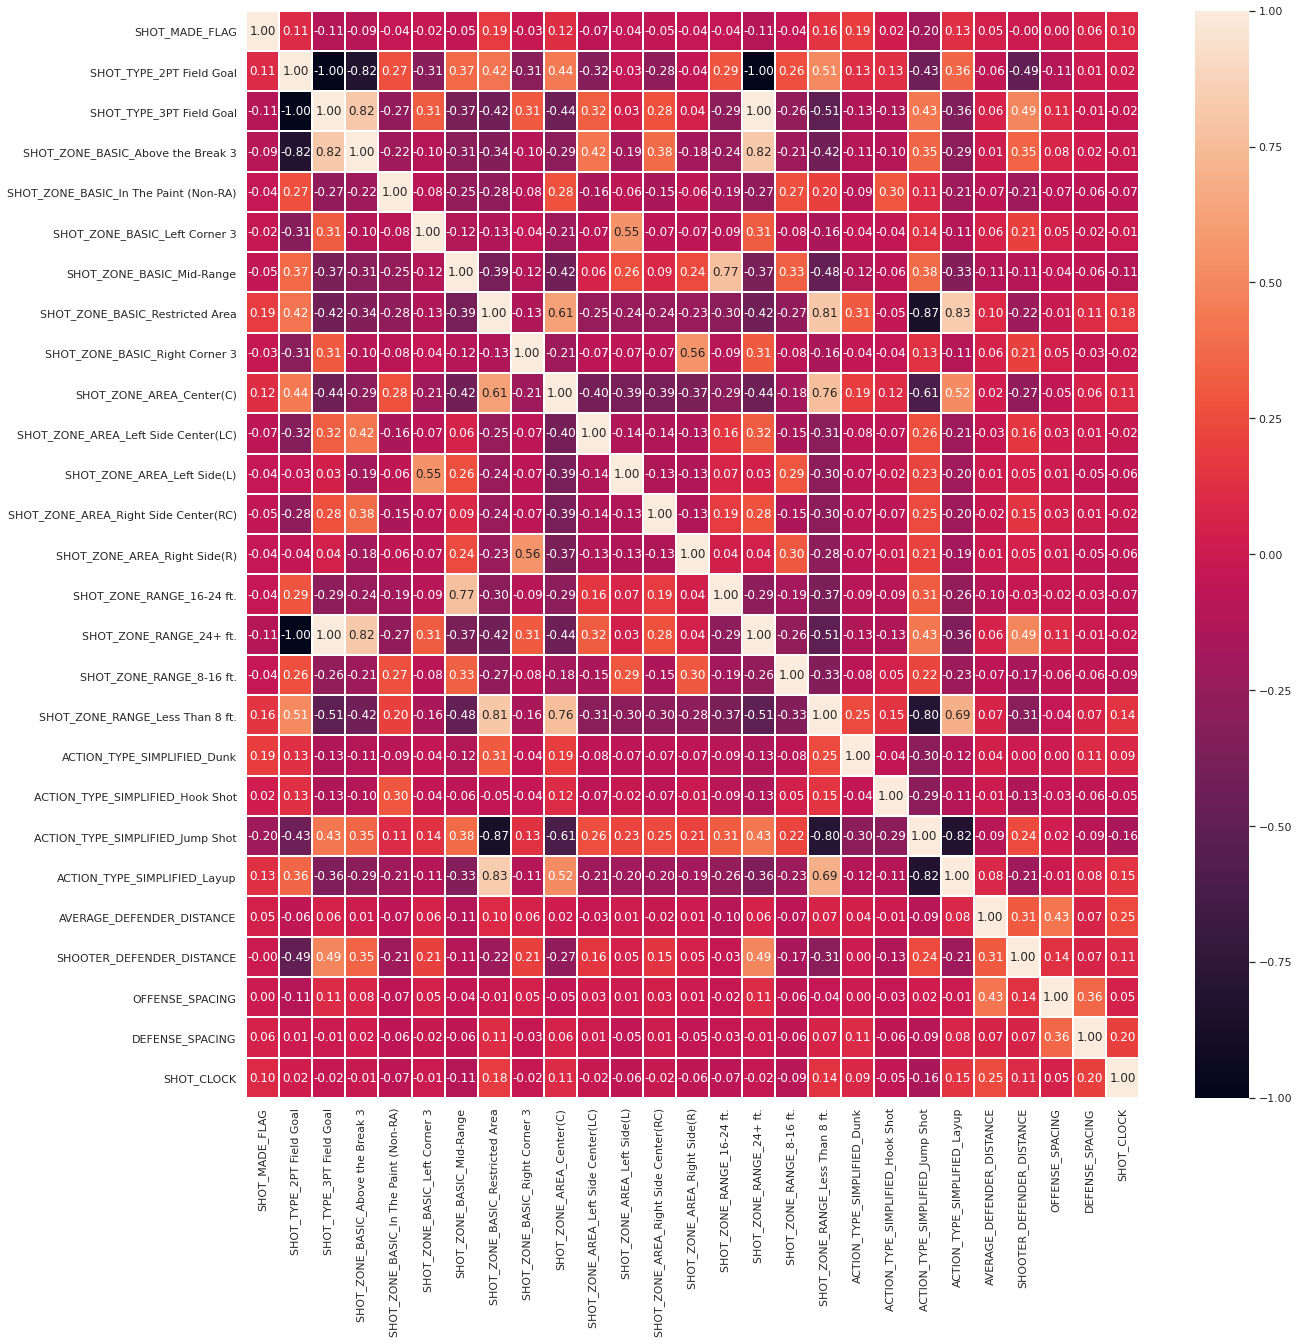

In [18]:
corr = train.corr()

f,ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr, annot = True, linewidths=1.5 , fmt = '.2f',ax=ax)
plt.show()

In [19]:
def classification_metrics(actual, pred, msg):
    cm = confusion_matrix(actual, pred)

    plt.figure()
    ax= plt.subplot()
    sns.heatmap(cm, annot = True, fmt = 'g')

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Made', 'Missed']) 
    ax.yaxis.set_ticklabels(['Made', 'Missed'])   
    plt.show()       
    sensitivity = cm[1][1]/(cm[1][0] + cm[1][1])
    specifity = cm[0][0]/(cm[0][0] + cm[0][1])
    accuracy = (cm[0][0] + cm[1][1]) / np.sum(cm)
    
    print(msg, '\n')
    print('accuracy:    ', round(accuracy,2), 
      '\nsensitivity: ', round(sensitivity,2), 
      '\nspecifity:   ', round(specifity,2))

In [20]:
train_X.columns

Index(['SHOT_TYPE_2PT Field Goal', 'SHOT_TYPE_3PT Field Goal',
       'SHOT_ZONE_BASIC_Above the Break 3',
       'SHOT_ZONE_BASIC_In The Paint (Non-RA)',
       'SHOT_ZONE_BASIC_Left Corner 3', 'SHOT_ZONE_BASIC_Mid-Range',
       'SHOT_ZONE_BASIC_Restricted Area', 'SHOT_ZONE_BASIC_Right Corner 3',
       'SHOT_ZONE_AREA_Center(C)', 'SHOT_ZONE_AREA_Left Side Center(LC)',
       'SHOT_ZONE_AREA_Left Side(L)', 'SHOT_ZONE_AREA_Right Side Center(RC)',
       'SHOT_ZONE_AREA_Right Side(R)', 'SHOT_ZONE_RANGE_16-24 ft.',
       'SHOT_ZONE_RANGE_24+ ft.', 'SHOT_ZONE_RANGE_8-16 ft.',
       'SHOT_ZONE_RANGE_Less Than 8 ft.', 'ACTION_TYPE_SIMPLIFIED_Dunk',
       'ACTION_TYPE_SIMPLIFIED_Hook Shot', 'ACTION_TYPE_SIMPLIFIED_Jump Shot',
       'ACTION_TYPE_SIMPLIFIED_Layup', 'AVERAGE_DEFENDER_DISTANCE',
       'SHOOTER_DEFENDER_DISTANCE', 'OFFENSE_SPACING', 'DEFENSE_SPACING',
       'SHOT_CLOCK'],
      dtype='object')

In [21]:
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 137, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 137, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

def plot_shooting(df, prediction, algorithm = ''):
    results = []
    index = 0

    for _, row in df.iterrows():
        temp = row.to_dict()
        shot_type_cols = ['SHOT_TYPE_3PT Field Goal', 'SHOT_TYPE_2PT Field Goal']
        temp['SHOT_TYPE'] = shot_type_cols[0].split('_')[2]
        for col in shot_type_cols:
            temp['SHOT_TYPE'] = col.split('_')[2] if row[col] == 1 else temp['SHOT_TYPE']

        shot_zone_cols = ['SHOT_ZONE_BASIC_Above the Break 3',
           'SHOT_ZONE_BASIC_In The Paint (Non-RA)',
           'SHOT_ZONE_BASIC_Left Corner 3', 'SHOT_ZONE_BASIC_Mid-Range',
           'SHOT_ZONE_BASIC_Restricted Area', 'SHOT_ZONE_BASIC_Right Corner 3',]

        temp['SHOT_ZONE_BASIC'] = shot_zone_cols[0].split('_')[3]
        for col in shot_zone_cols:
            temp['SHOT_ZONE_BASIC'] = col.split('_')[3] if row[col] == 1 else temp['SHOT_ZONE_BASIC']

        shot_zone_area_cols = ['SHOT_ZONE_AREA_Center(C)', 'SHOT_ZONE_AREA_Left Side Center(LC)',
           'SHOT_ZONE_AREA_Left Side(L)', 'SHOT_ZONE_AREA_Right Side Center(RC)',
           'SHOT_ZONE_AREA_Right Side(R)']
        temp['SHOT_ZONE_AREA'] = shot_zone_area_cols[0].split('_')[3]
        for col in shot_zone_area_cols:
            temp['SHOT_ZONE_AREA'] = col.split('_')[3] if row[col] == 1 else temp['SHOT_ZONE_AREA']

        shot_zone_range_cols = ['SHOT_ZONE_RANGE_16-24 ft.',
           'SHOT_ZONE_RANGE_24+ ft.', 'SHOT_ZONE_RANGE_8-16 ft.',
           'SHOT_ZONE_RANGE_Less Than 8 ft.']

        temp['SHOT_ZONE_RANGE'] = shot_zone_range_cols[0].split('_')[3]
        for col in shot_zone_range_cols:
            temp['SHOT_ZONE_RANGE'] = col.split('_')[3] if row[col] == 1 else temp['SHOT_ZONE_RANGE']

        action_type_cols = ['ACTION_TYPE_SIMPLIFIED_Dunk',
           'ACTION_TYPE_SIMPLIFIED_Hook Shot', 'ACTION_TYPE_SIMPLIFIED_Jump Shot',
           'ACTION_TYPE_SIMPLIFIED_Layup']

        temp['ACTION_TYPE'] = action_type_cols[0].split('_')[3]
        for col in action_type_cols:
            temp['ACTION_TYPE'] = col.split('_')[3] if row[col] == 1 else temp['ACTION_TYPE']

        temp['SHOT_MADE_FLAG'] = prediction[index]
        index = index + 1
        results.append(temp)

    results_df = pd.DataFrame(results)
        
    restricted_area_attempts = len(results_df[(results_df['SHOT_ZONE_BASIC'] == 'Restricted Area')])
    restricted_area_makes = len(results_df[(results_df['SHOT_ZONE_BASIC'] == 'Restricted Area') & (results_df['SHOT_MADE_FLAG'] == 1)])
    restricted_area_percentage = restricted_area_makes * 100 / restricted_area_attempts
    restricted_area_points_per_shot = restricted_area_makes * 2 / restricted_area_attempts

    non_restricted_area_attempts = len(results_df[(results_df['SHOT_ZONE_BASIC'] == 'In The Paint (Non-RA)')])
    non_restricted_area_makes = len(results_df[(results_df['SHOT_ZONE_BASIC'] == 'In The Paint (Non-RA)') & (results_df['SHOT_MADE_FLAG'] == 1)])
    non_restricted_area_percentage = non_restricted_area_makes * 100 / non_restricted_area_attempts
    non_restricted_area_points_per_shot = non_restricted_area_makes * 2 / non_restricted_area_attempts

    midrange_left_attempts = len(results_df[(results_df['SHOT_ZONE_BASIC'] == 'Mid-Range') & (results_df['SHOT_ZONE_AREA'] == 'Left Side(L)')])
    midrange_left_makes = len(results_df[(results_df['SHOT_ZONE_BASIC'] == 'Mid-Range') & (results_df['SHOT_ZONE_AREA'] == 'Left Side(L)') & (results_df['SHOT_MADE_FLAG'] == 1)])
    midrange_left_percentage = midrange_left_makes * 100 / midrange_left_attempts
    midrange_left_points_per_shot = midrange_left_makes * 2 / midrange_left_attempts

    midrange_left_center_attempts = len(results_df[(results_df['SHOT_ZONE_BASIC'] == 'Mid-Range') & (results_df['SHOT_ZONE_AREA'] == 'Left Side Center(LC)')])
    midrange_left_center_makes = len(results_df[(results_df['SHOT_ZONE_BASIC'] == 'Mid-Range') & (results_df['SHOT_ZONE_AREA'] == 'Left Side Center(LC)') & (results_df['SHOT_MADE_FLAG'] == 1)])
    midrange_left_center_percentage = midrange_left_center_makes * 100 / midrange_left_center_attempts
    midrange_left_center_points_per_shot = midrange_left_center_makes * 2 / midrange_left_center_attempts

    midrange_center_attempts = len(results_df[(results_df['SHOT_ZONE_BASIC'] == 'Mid-Range') & (results_df['SHOT_ZONE_AREA'] == 'Center(C)')])
    midrange_center_makes = len(results_df[(results_df['SHOT_ZONE_BASIC'] == 'Mid-Range') & (results_df['SHOT_ZONE_AREA'] == 'Center(C)') & (results_df['SHOT_MADE_FLAG'] == 1)])
    midrange_center_percentage = midrange_center_makes * 100 / midrange_center_attempts
    midrange_center_points_per_shot = midrange_center_makes * 2 / midrange_center_attempts

    midrange_right_center_attempts = len(results_df[(results_df['SHOT_ZONE_BASIC'] == 'Mid-Range') & (results_df['SHOT_ZONE_AREA'] == 'Right Side Center(RC)')])
    midrange_right_center_makes = len(results_df[(results_df['SHOT_ZONE_BASIC'] == 'Mid-Range') & (results_df['SHOT_ZONE_AREA'] == 'Right Side Center(RC)') & (results_df['SHOT_MADE_FLAG'] == 1)])
    midrange_right_center_percentage = midrange_right_center_makes * 100 / midrange_right_center_attempts
    midrange_right_center_points_per_shot = midrange_right_center_makes * 2 / midrange_right_center_attempts

    midrange_right_attempts = len(results_df[(results_df['SHOT_ZONE_BASIC'] == 'Mid-Range') & (results_df['SHOT_ZONE_AREA'] == 'Right Side(R)')])
    midrange_right_makes = len(results_df[(results_df['SHOT_ZONE_BASIC'] == 'Mid-Range') & (results_df['SHOT_ZONE_AREA'] == 'Right Side(R)') & (results_df['SHOT_MADE_FLAG'] == 1)])
    midrange_right_percentage = midrange_right_makes * 100 / midrange_right_attempts
    midrange_right_points_per_shot = midrange_right_makes * 2 / midrange_right_attempts

    left_corner_threes_attempts = len(results_df[(results_df['SHOT_ZONE_BASIC'] == 'Left Corner 3') & (results_df['SHOT_ZONE_AREA'] == 'Left Side(L)')])
    left_corner_threes_makes = len(results_df[(results_df['SHOT_ZONE_BASIC'] == 'Left Corner 3') & (results_df['SHOT_ZONE_AREA'] == 'Left Side(L)') & (results_df['SHOT_MADE_FLAG'] == 1)])
    left_corner_threes_percentage = left_corner_threes_makes * 100 / left_corner_threes_attempts
    left_corner_threes_points_per_shot = left_corner_threes_makes * 3 / left_corner_threes_attempts

    left_center_threes_attempts = len(results_df[(results_df['SHOT_ZONE_BASIC'] == 'Above the Break 3') & (results_df['SHOT_ZONE_AREA'] == 'Left Side Center(LC)')])
    left_center_threes_makes = len(results_df[(results_df['SHOT_ZONE_BASIC'] == 'Above the Break 3') & (results_df['SHOT_ZONE_AREA'] == 'Left Side Center(LC)') & (results_df['SHOT_MADE_FLAG'] == 1)])
    left_center_threes_percentage = left_center_threes_makes * 100 / left_center_threes_attempts
    left_center_threes_points_per_shot = left_center_threes_makes * 3 / left_center_threes_attempts

    center_threes_attempts = len(results_df[(results_df['SHOT_ZONE_BASIC'] == 'Above the Break 3') & (results_df['SHOT_ZONE_AREA'] == 'Center(C)')])
    center_threes_makes = len(results_df[(results_df['SHOT_ZONE_BASIC'] == 'Above the Break 3') & (results_df['SHOT_ZONE_AREA'] == 'Center(C)') & (results_df['SHOT_MADE_FLAG'] == 1)])
    center_threes_percentage = center_threes_makes * 100 / center_threes_attempts
    center_threes_points_per_shot = center_threes_makes * 3 / center_threes_attempts

    right_center_threes_attempts = len(results_df[(results_df['SHOT_ZONE_BASIC'] == 'Above the Break 3') & (results_df['SHOT_ZONE_AREA'] == 'Right Side Center(RC)')])
    right_center_threes_makes = len(results_df[(results_df['SHOT_ZONE_BASIC'] == 'Above the Break 3') & (results_df['SHOT_ZONE_AREA'] == 'Right Side Center(RC)') & (results_df['SHOT_MADE_FLAG'] == 1)])
    right_center_threes_percentage = right_center_threes_makes * 100 / right_center_threes_attempts
    right_center_threes_points_per_shot = right_center_threes_makes * 3 / right_center_threes_attempts

    right_corner_threes_attempts = len(results_df[(results_df['SHOT_ZONE_BASIC'] == 'Right Corner 3') & (results_df['SHOT_ZONE_AREA'] == 'Right Side(R)')])
    right_corner_threes_makes = len(results_df[(results_df['SHOT_ZONE_BASIC'] == 'Right Corner 3') & (results_df['SHOT_ZONE_AREA'] == 'Right Side(R)') & (results_df['SHOT_MADE_FLAG'] == 1)])
    right_corner_threes_percentage = right_corner_threes_makes * 100 / right_corner_threes_attempts
    right_corner_threes_points_per_shot = right_corner_threes_makes * 3 / right_corner_threes_attempts

    fig, ax = plt.subplots(figsize=(12, 11))

    draw_court(ax, outer_lines=True)

    ax.axis("off")
    ax.set_xlim(251,-250)
    ax.set_ylim(-48,424)
    ax.margins(0,0)

    ax.text(25, 15, '{:.2f}%'.format(restricted_area_percentage), fontsize=20)
    ax.text(25, 100, '{:.2f}%'.format(non_restricted_area_percentage), fontsize=20)
    ax.text(-130, 5, '{:.2f}%'.format(midrange_left_percentage), fontsize=20, rotation=270)
    ax.text(-100, 130, '{:.2f}%'.format(midrange_left_center_percentage), fontsize=20, rotation=-45)
    ax.text(25, 175, '{:.2f}%'.format(midrange_center_percentage), fontsize=20)
    ax.text(150, 130, '{:.2f}%'.format(midrange_right_center_percentage), fontsize=20, rotation=45)
    ax.text(170, 5, '{:.2f}%'.format(midrange_right_percentage), fontsize=20, rotation=90)
    ax.text(-225, 5, '{:.2f}%'.format(left_corner_threes_percentage), fontsize=20, rotation=270)
    ax.text(-115, 185, '{:.2f}%'.format(left_center_threes_percentage), fontsize=20, rotation=-35)
    ax.text(25, 245, '{:.2f}%'.format(center_threes_percentage), fontsize=20)
    ax.text(180, 175, '{:.2f}%'.format(right_center_threes_percentage), fontsize=20, rotation=40)
    ax.text(245, 5, '{:.2f}%'.format(right_corner_threes_percentage), fontsize=20, rotation=90)

    size=150

    ax.set_title('Shooting % based on zones', fontsize=14)
    
    if algorithm:
        plt.savefig('../../images/{} shooting percentage based on zones.png'.format(algorithm), bbox_inches='tight')    
    
    fig, ax = plt.subplots(figsize=(12, 11))

    draw_court(ax, outer_lines=True)

    ax.axis("off")
    ax.set_xlim(251,-250)
    ax.set_ylim(-48,424)
    ax.margins(0,0)

    ax.text(17, 15, '{:.2f}'.format(restricted_area_points_per_shot), fontsize=20)
    ax.text(17, 100, '{:.2f}'.format(non_restricted_area_points_per_shot), fontsize=20)
    ax.text(-130, 5, '{:.2f}'.format(midrange_left_points_per_shot), fontsize=20, rotation=270)
    ax.text(-100, 130, '{:.2f}'.format(midrange_left_center_points_per_shot), fontsize=20, rotation=-45)
    ax.text(17, 175, '{:.2f}'.format(midrange_center_points_per_shot), fontsize=20)
    ax.text(150, 130, '{:.2f}'.format(midrange_right_center_points_per_shot), fontsize=20, rotation=45)
    ax.text(170, 5, '{:.2f}'.format(midrange_right_points_per_shot), fontsize=20, rotation=90)
    ax.text(-225, 5, '{:.2f}'.format(left_corner_threes_points_per_shot), fontsize=20, rotation=270)
    ax.text(-130, 185, '{:.2f}'.format(left_center_threes_points_per_shot), fontsize=20, rotation=-35)
    ax.text(25, 245, '{:.2f}'.format(center_threes_points_per_shot), fontsize=20)
    ax.text(180, 175, '{:.2f}'.format(right_center_threes_points_per_shot), fontsize=20, rotation=40)
    ax.text(245, 5, '{:.2f}'.format(right_corner_threes_points_per_shot), fontsize=20, rotation=90)

    size=150

    ax.set_title('Points per shot based on zones', fontsize=14)
    
    if algorithm:
        plt.savefig('../../images/{} points per shot based on zones.png'.format(algorithm), bbox_inches='tight')    

## Using Logistic Regression

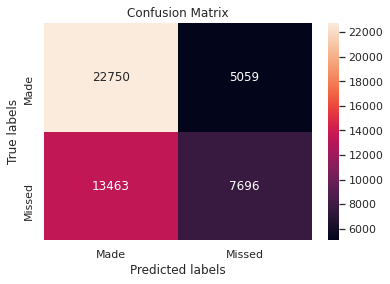

TRAIN 

accuracy:     0.62 
sensitivity:  0.36 
specifity:    0.82


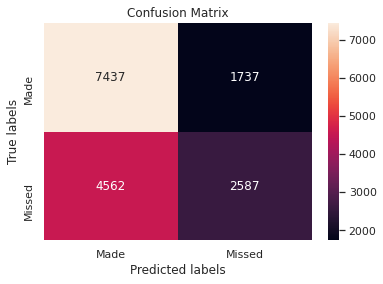

TEST 

accuracy:     0.61 
sensitivity:  0.36 
specifity:    0.81


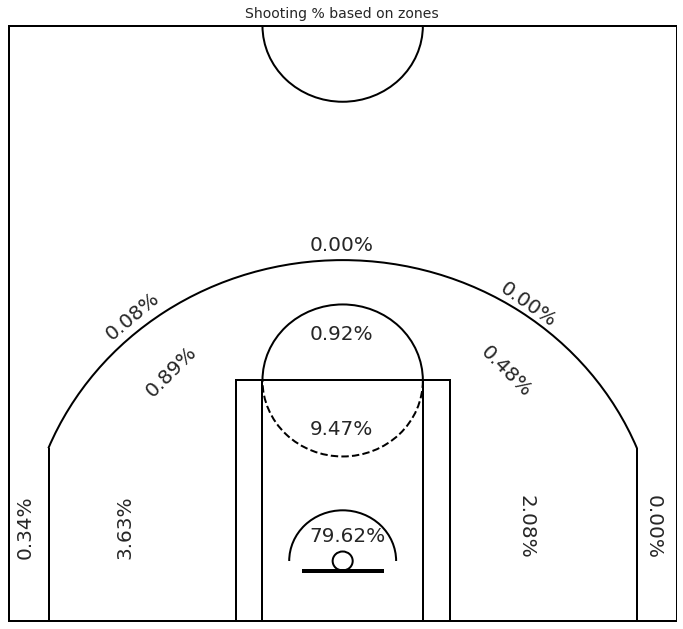

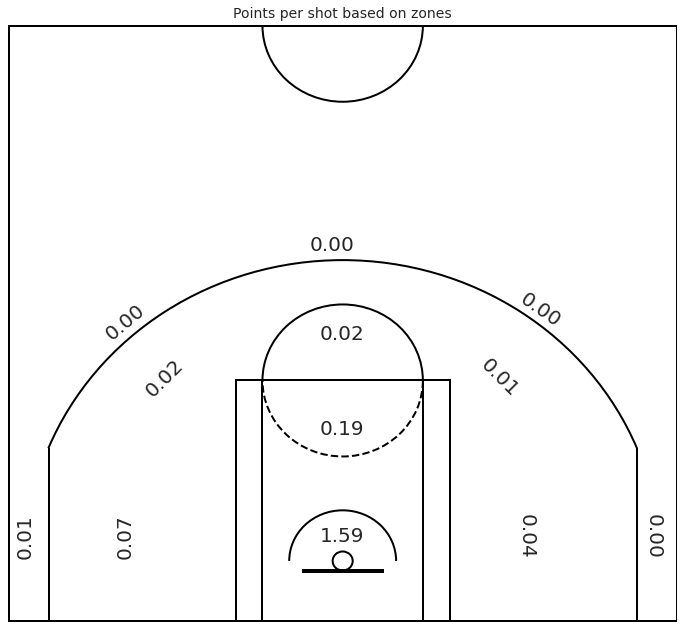

In [22]:
model = LogisticRegression()
model.fit(train_X, train_Y)

prediction = model.predict(test_X)
train_prediction = model.predict(train_X)

classification_metrics(actual = train_Y, pred = train_prediction, msg = 'TRAIN')
classification_metrics(actual = test_Y, pred = prediction, msg = 'TEST')

plot_shooting(test_X, prediction, 'Logistic Regression')

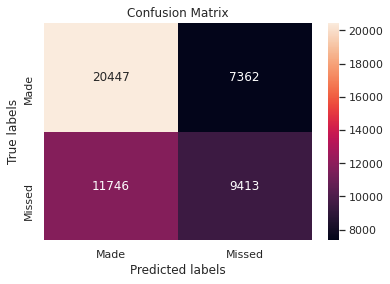

TRAIN 

accuracy:     0.61 
sensitivity:  0.44 
specifity:    0.74


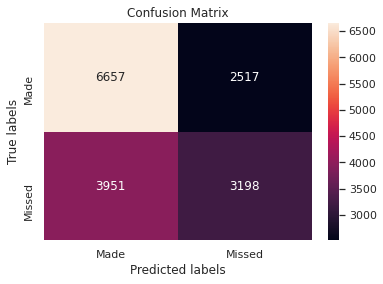

TEST 

accuracy:     0.6 
sensitivity:  0.45 
specifity:    0.73


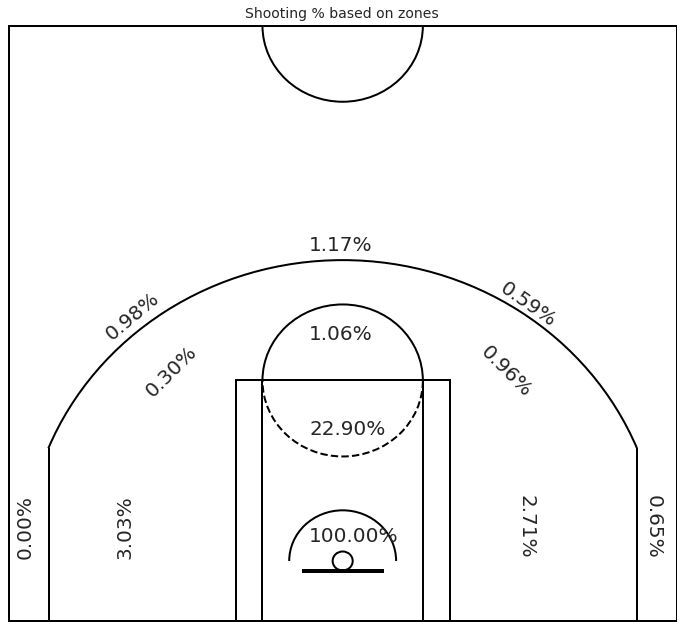

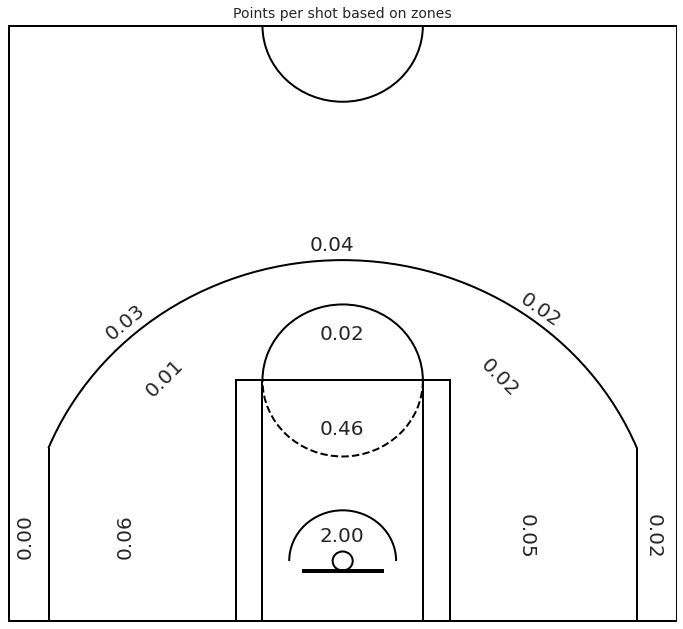

In [23]:
model = GaussianNB()
model.fit(train_X, train_Y)

prediction = model.predict(test_X)
train_prediction = model.predict(train_X)

classification_metrics(actual = train_Y, pred = train_prediction, msg = 'TRAIN')
classification_metrics(actual = test_Y, pred = prediction, msg = 'TEST')

plot_shooting(test_X, prediction, 'Gaussian NB')

## Using KNN

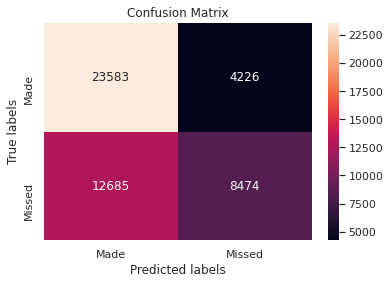

TRAIN 

accuracy:     0.65 
sensitivity:  0.4 
specifity:    0.85


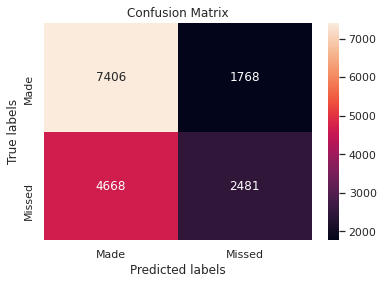

TEST 

accuracy:     0.61 
sensitivity:  0.35 
specifity:    0.81


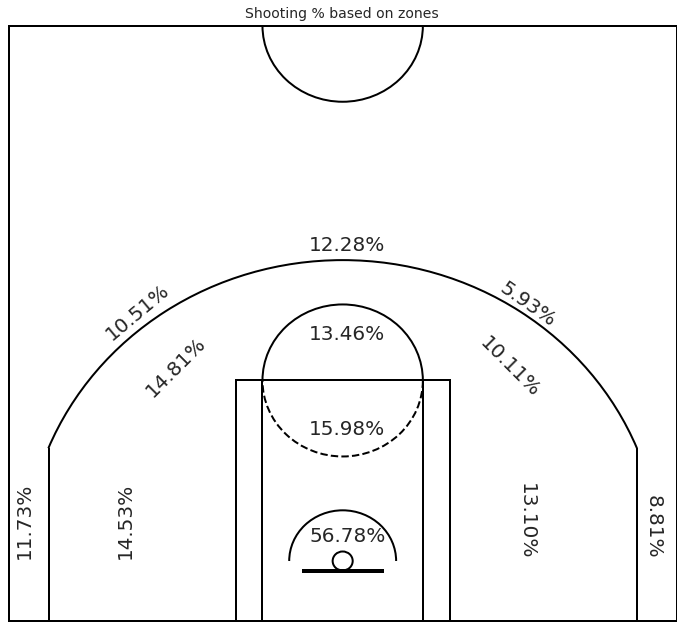

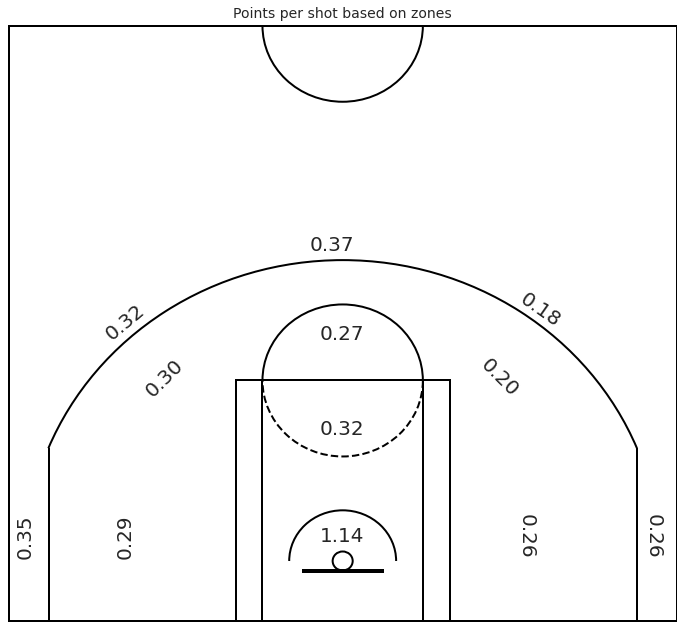

In [24]:
model = KNeighborsClassifier(n_neighbors=20)
model.fit(train_X, train_Y)

prediction = model.predict(test_X)
train_prediction = model.predict(train_X)

classification_metrics(actual = train_Y, pred = train_prediction, msg = 'TRAIN')
classification_metrics(actual = test_Y, pred = prediction, msg = 'TEST')

plot_shooting(test_X, prediction, 'KNN')

## Using decision trees

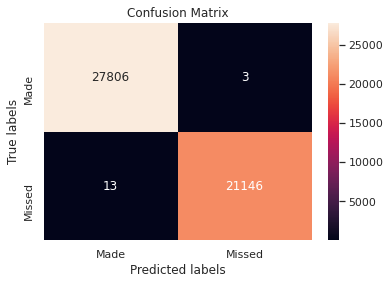

TRAIN 

accuracy:     1.0 
sensitivity:  1.0 
specifity:    1.0


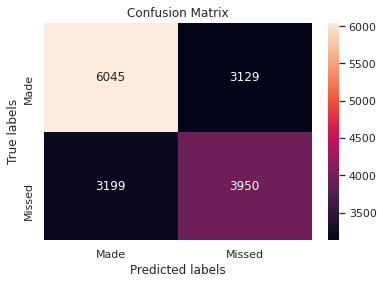

TEST 

accuracy:     0.61 
sensitivity:  0.55 
specifity:    0.66


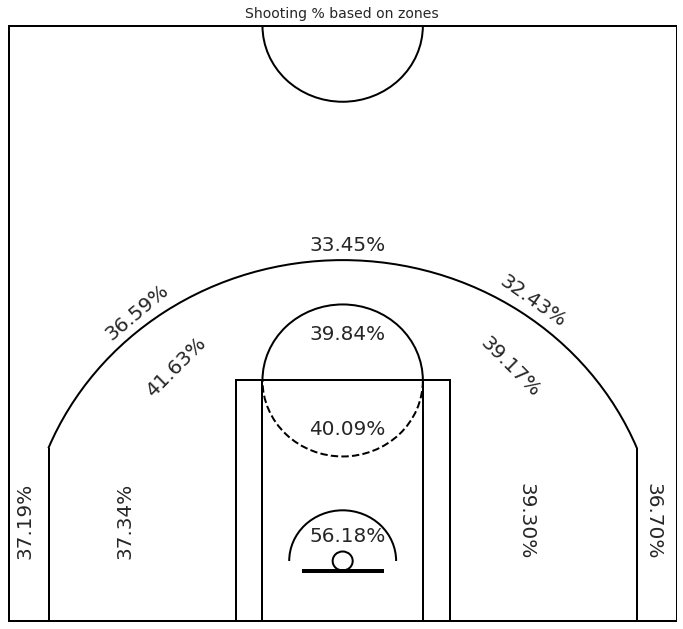

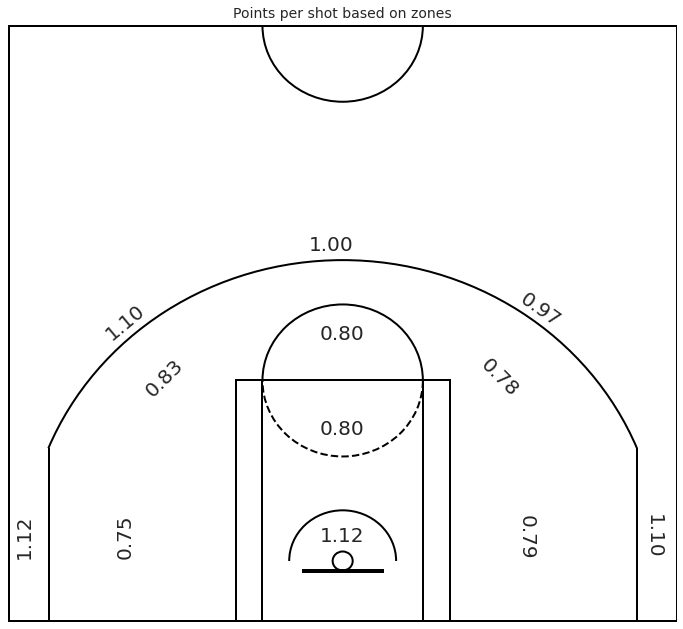

In [25]:
model = DecisionTreeClassifier()
model.fit(train_X, train_Y)

prediction = model.predict(test_X)
train_prediction = model.predict(train_X)

classification_metrics(actual = train_Y, pred = train_prediction, msg = 'TRAIN')
classification_metrics(actual = test_Y, pred = prediction, msg = 'TEST')

plot_shooting(test_X, prediction, 'Decision tree')

## Using Random Forest Classifier

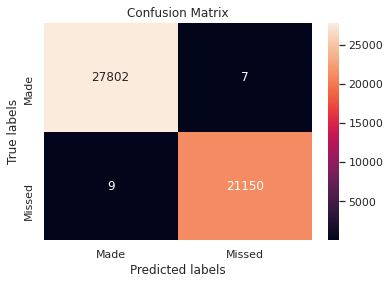

TRAIN 

accuracy:     1.0 
sensitivity:  1.0 
specifity:    1.0


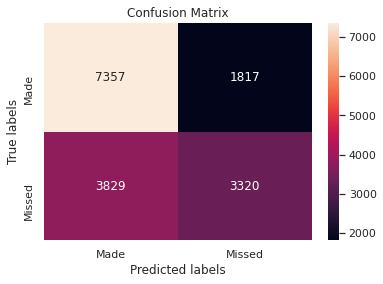

TEST 

accuracy:     0.65 
sensitivity:  0.46 
specifity:    0.8


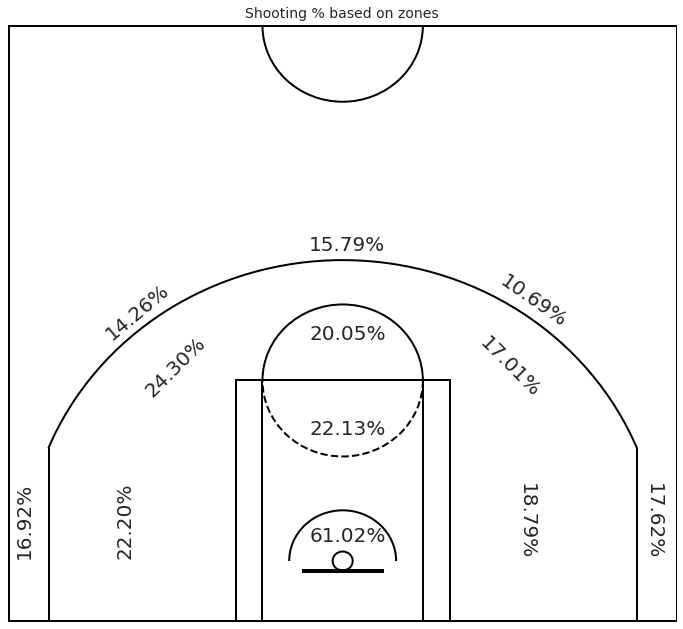

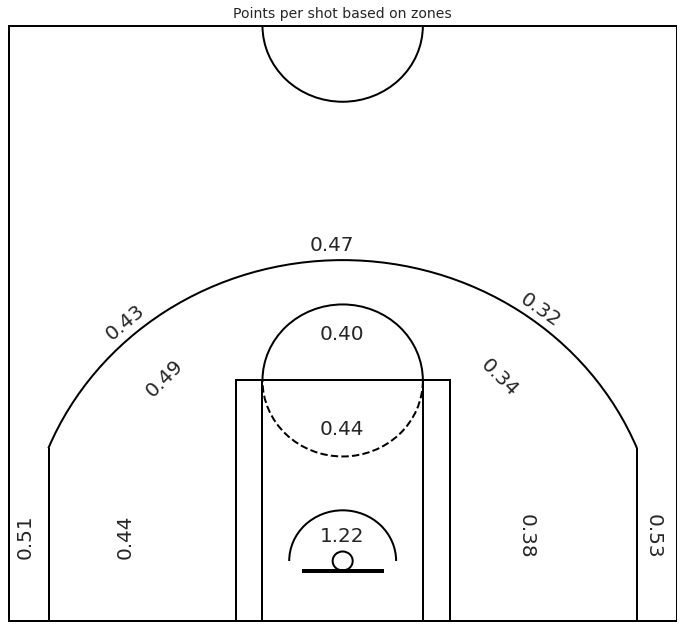

In [26]:
model = RandomForestClassifier()

model.fit(train_X, train_Y)

prediction = model.predict(test_X)
train_prediction = model.predict(train_X)

classification_metrics(actual = train_Y, pred = train_prediction, msg = 'TRAIN')
classification_metrics(actual = test_Y, pred = prediction, msg = 'TEST')

plot_shooting(test_X, prediction, 'Random Forest')

## Using XGBoost

/home/aviskarkc10/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:05:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


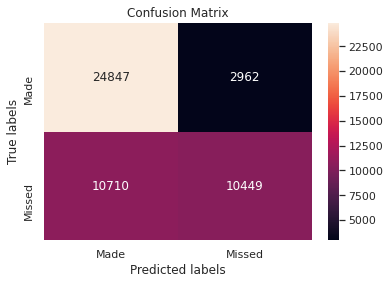

TRAIN 

accuracy:     0.72 
sensitivity:  0.49 
specifity:    0.89


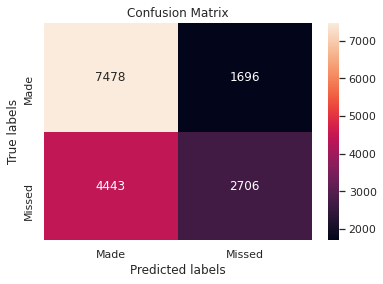

TEST 

accuracy:     0.62 
sensitivity:  0.38 
specifity:    0.82


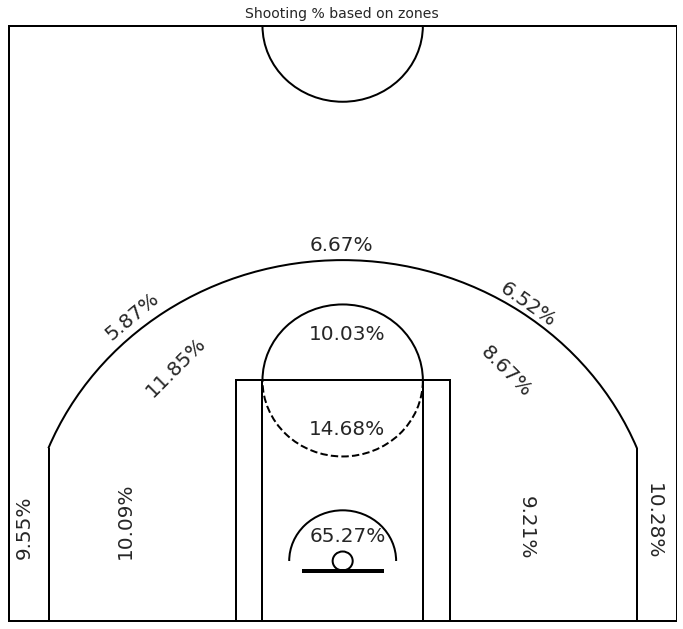

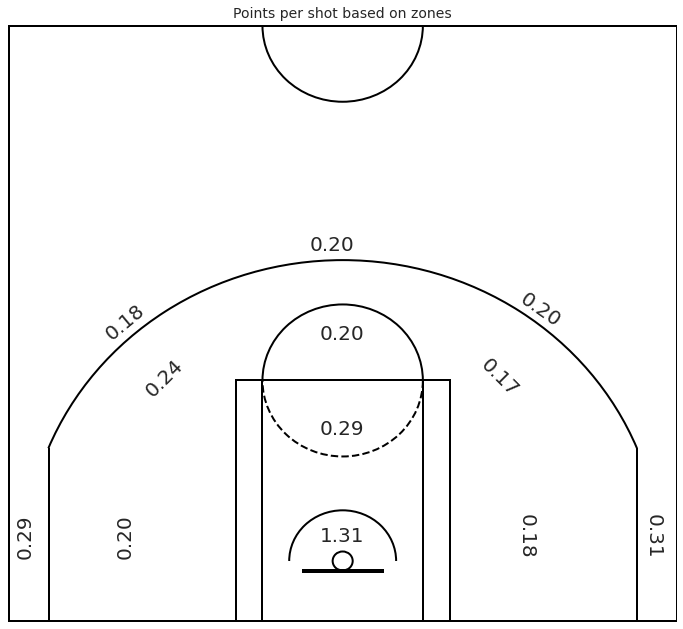

In [27]:
model = XGBClassifier()

model.fit(train_X, train_Y)

prediction = model.predict(test_X)
train_prediction = model.predict(train_X)

classification_metrics(actual = train_Y, pred = train_prediction, msg = 'TRAIN')
classification_metrics(actual = test_Y, pred = prediction, msg = 'TEST')

plot_shooting(test_X, prediction, 'XGBoost')

## Using SVC

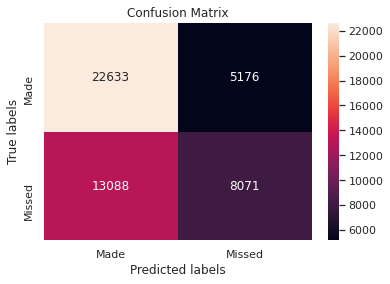

TRAIN 

accuracy:     0.63 
sensitivity:  0.38 
specifity:    0.81


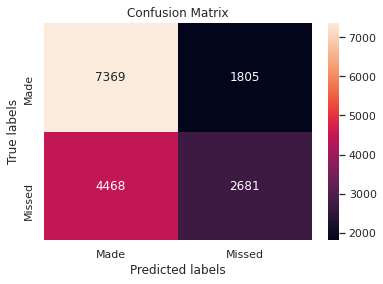

TEST 

accuracy:     0.62 
sensitivity:  0.38 
specifity:    0.8


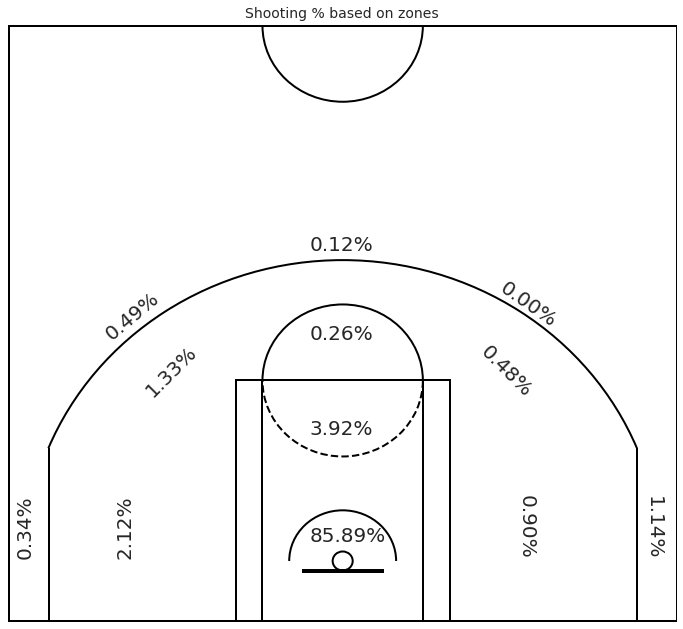

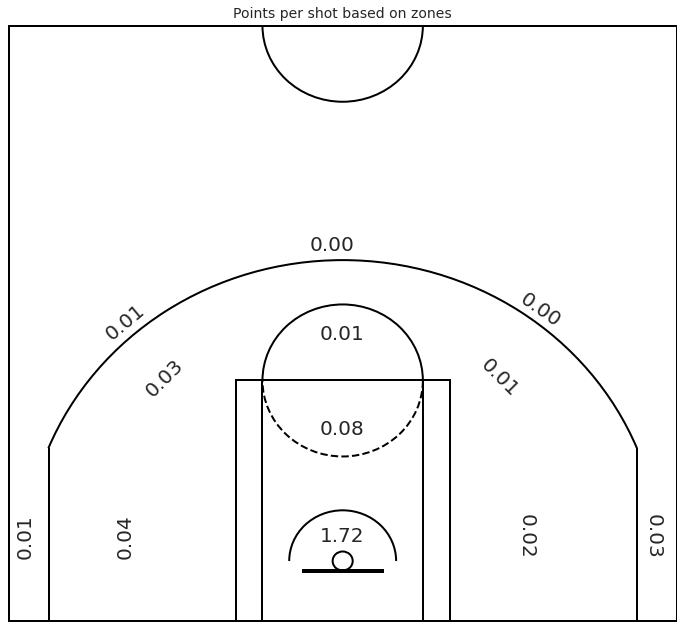

In [28]:
model = SVC()

model.fit(train_X, train_Y)

prediction = model.predict(test_X)
train_prediction = model.predict(train_X)

classification_metrics(actual = train_Y, pred = train_prediction, msg = 'TRAIN')
classification_metrics(actual = test_Y, pred = prediction, msg = 'TEST')

plot_shooting(test_X, prediction, 'SVC')

## Let's take a closer look at the results of the Logistic Regression model

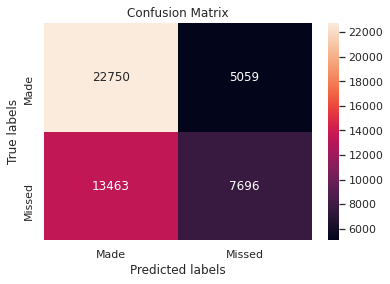

TRAIN 

accuracy:     0.62 
sensitivity:  0.36 
specifity:    0.82


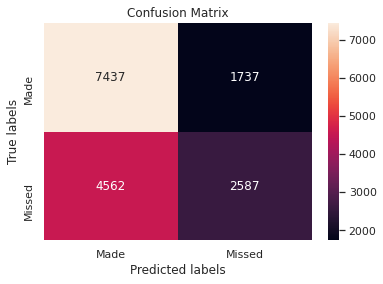

TEST 

accuracy:     0.61 
sensitivity:  0.36 
specifity:    0.81


In [29]:
model = LogisticRegression()
model.fit(train_X, train_Y)

prediction = model.predict(test_X)
train_prediction = model.predict(train_X)

classification_metrics(actual = train_Y, pred = train_prediction, msg = 'TRAIN')
classification_metrics(actual = test_Y, pred = prediction, msg = 'TEST')

**Prediciting shots that will go in and won't go in is pretty difficult consdidering the league average for 2PT Field Goals is 50% and players make around 35% of their 3s.**

**For our model it seems our model has foregone Sensitivity in order to improve the accuracy. Below we can see exactly why:**

## Here we see that our model is biaseds towards 2 point shots. Those especially in the restricted area. This is warranted as most of the shots are in that zone and so are most of the made shots as well.

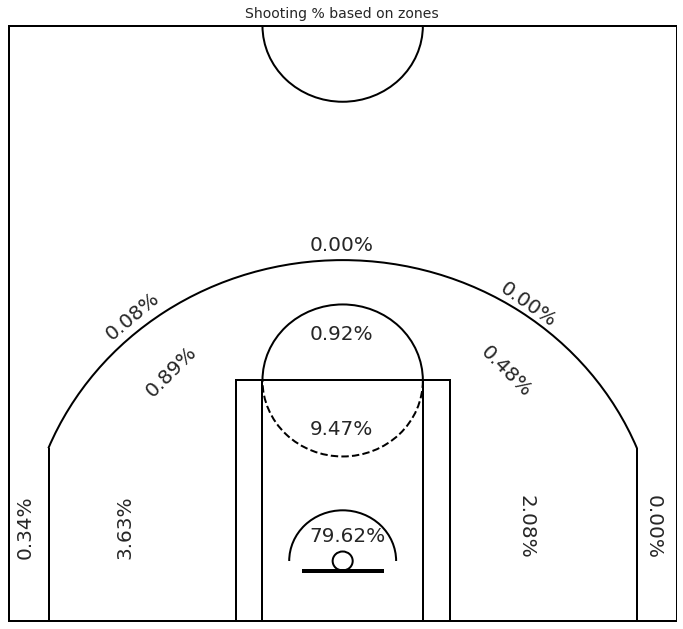

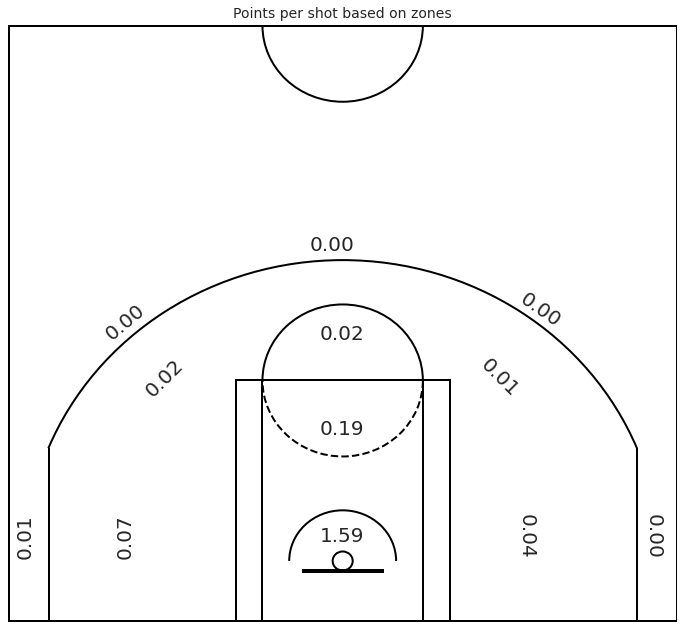

In [30]:
plot_shooting(test_X, prediction)

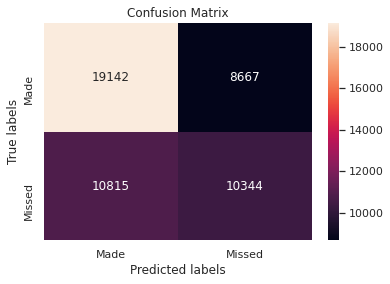

TRAIN 

accuracy:     0.6 
sensitivity:  0.49 
specifity:    0.69


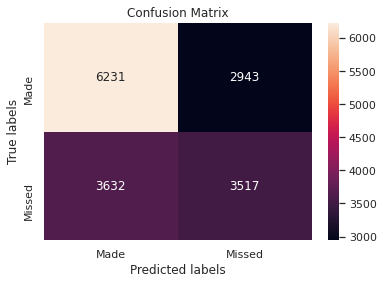

TEST 

accuracy:     0.6 
sensitivity:  0.49 
specifity:    0.68
tuned hpyerparameters :(best parameters)  {'C': 0.0001}
accuracy : 0.491185546950919


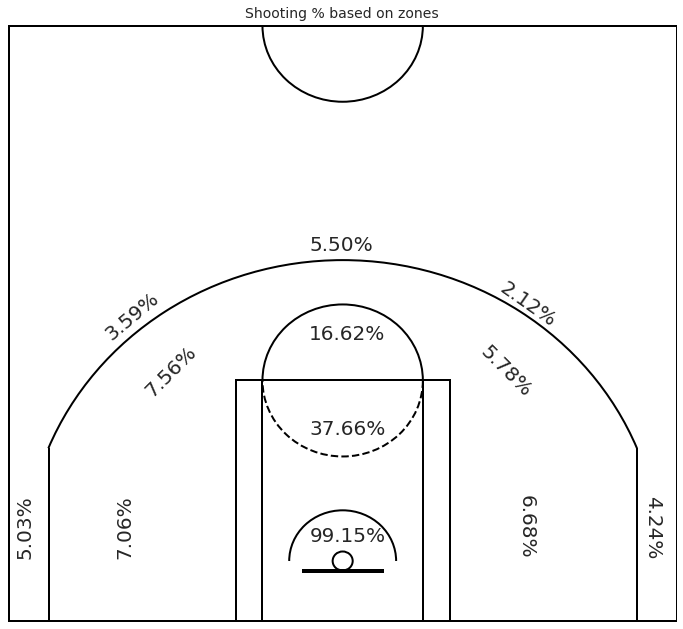

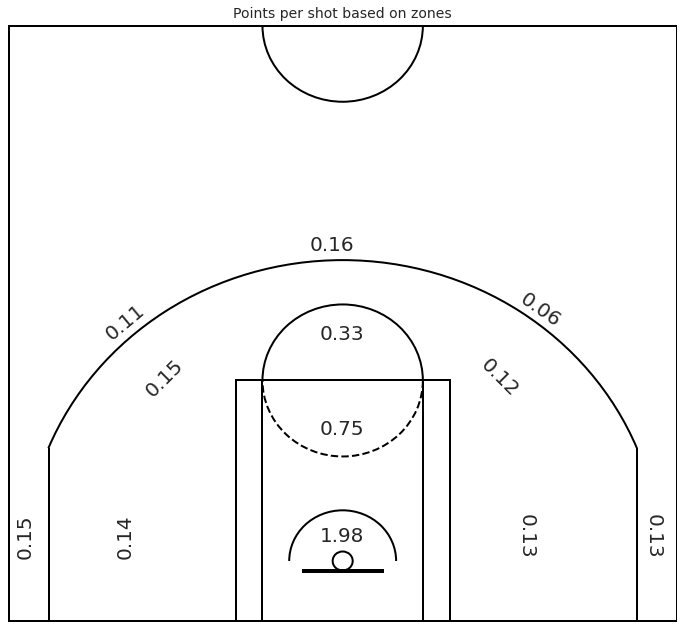

In [31]:
grid={"C":np.logspace(-4, 4, 20) }

model = LogisticRegression(class_weight='balanced', max_iter=500)
model_cv = GridSearchCV(model, grid, cv=5, scoring='recall')

model_cv.fit(train_X, train_Y)

prediction = model_cv.predict(test_X)
train_prediction = model_cv.predict(train_X)

classification_metrics(actual = train_Y, pred = train_prediction, msg = 'TRAIN')
classification_metrics(actual = test_Y, pred = prediction, msg = 'TEST')
plot_shooting(test_X, prediction)
print("tuned hpyerparameters :(best parameters) ",model_cv.best_params_)
print("accuracy :",model_cv.best_score_)

## Of the models we have Decision Trees, XGBoost and Random Forest Classifiers seem to have done the most well. So let's focus on those and try to further improve them in other notebooks